In [1]:
import numpy as np
import pandas as pd
from model.autoencoder import AutoEncoder
from model.vae import aligned_vae, vae, ae_from_vae, AE
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import diffusion_dist as diff
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from dataset import *
import scipy
import torchvision

In [2]:
# like pipeline in sklearn, create a pipeline for transformation
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
train_dataset = torchvision.datasets.MNIST(
    root = './torch_dataset', train = True, download = True, transform = transform
)
test_dataset = torchvision.datasets.MNIST(
    root = './torch_dataset', train=False, transform = transform, download = True
)
# useful function. Combines a dataset and a sampler, and provides an iterable over the given dataset.
train_loader = torch.utils.data.DataLoader(
    dataset = train_dataset, batch_size = 128, shuffle = True, num_workers = 4, pin_memory = True)

test_loader = torch.utils.data.DataLoader(
    dataset = train_dataset, batch_size = 32, shuffle = False, num_workers = 4 
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# AE

In [3]:
criterion = nn.MSELoss()

In [4]:
def train_mnist(model, data_loader):
    model.train()

    total_loss = 0
    total_loss_recon_rna = 0
    total_loss_kl = 0
    for batch_rna, label in data_loader:
        optimizer.zero_grad()
        # print(batch_rna.shape)
        batch_rna = batch_rna.view(-1,784).to(device)
        # recon_rna, mu, logvar = model(batch_rna)
        mu, recon_rna = model(batch_rna)
        # print(mu.shape)
        # print(z.shape)
        train_loss = criterion(recon_rna, batch_rna)
        train_loss.backward()

        total_loss += train_loss.item()

        optimizer.step()
    
    return total_loss / len(data_loader)

In [8]:
def test_mnist(model, data_loader):
    model.eval()
    test_loss = 0
    for data , label in data_loader:
        data = data.view(-1,784).to(device)
        # recon_rna, mu, logvar = model(data)
        mu, recon_rna = model(data)

        mu = mu.detach().cpu().numpy()
        test_loss += criterion(recon_rna, data).item() 
        break

    print("reconstruction loss", test_loss/len(data_loader))
    
    diff_ori = 0
    diff_recon = 0
    for j in np.arange(data.shape[0]):
        diff_ori += torch.norm(data[0,:] - data[j,:]).detach().item()
        diff_recon += torch.norm(recon_rna[0,:] - recon_rna[j,:]).detach().item()

    print("original difference between sample", diff_ori)
    print("reconstruction difference between samples", diff_recon)

    return mu, test_loss, recon_rna

In [6]:
# model_ae = ae_from_vae(in_channels = 28*28, latent_channels = 4, layer1_channels = 128, layer2_channels = 32).to(device)
model_ae = AE(n_features=784, n_embed = 2).to(device)
optimizer = torch.optim.Adam(model_ae.parameters(), lr=0.001)#, weight_decay=0.01)

for epoch in range(0, 21):
    loss = train_mnist(model_ae, data_loader = train_loader)
    if epoch % 5 == 0:
        log = "Epoch: {:03d}, Total loss: {:.5f}"
        print(log.format(epoch, loss))
        # print(mu)

Epoch: 000, Total loss: 0.06871
Epoch: 005, Total loss: 0.06733
Epoch: 010, Total loss: 0.06731
Epoch: 015, Total loss: 0.06731
Epoch: 020, Total loss: 0.06730


reconstruction loss 3.447380463282267e-05
original difference between sample 309.07257080078125
reconstruction difference between samples 8.989657658275974e-07


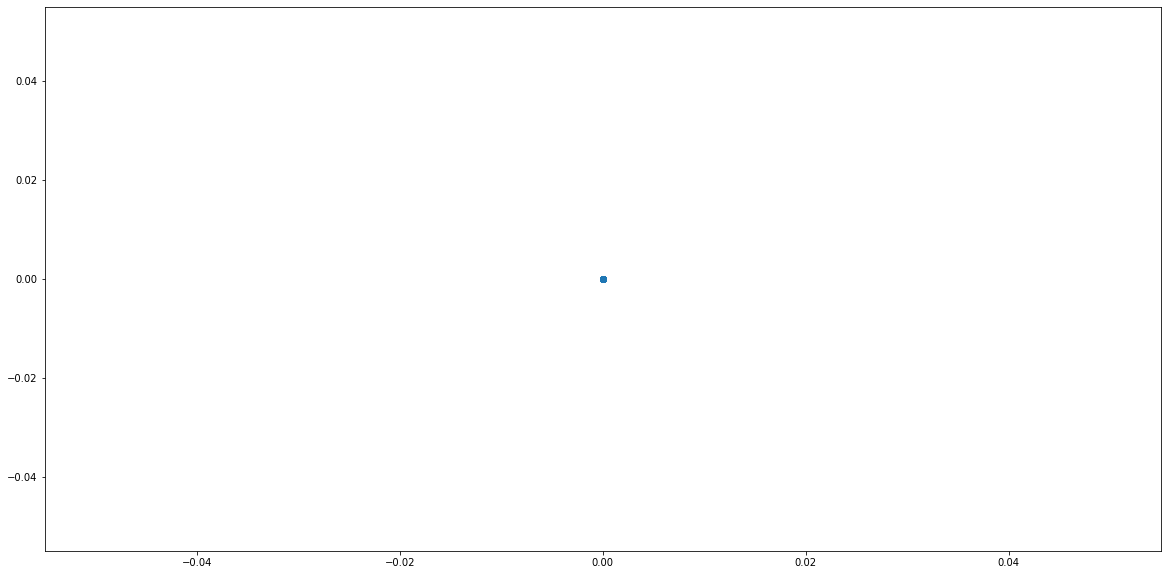

In [9]:
z, loss_val, recon_mnist = test_mnist(model_ae, test_loader)
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot()
ax.scatter(z[:,0], z[:,1])
plt.show()

In [10]:
z.shape

(32, 2)

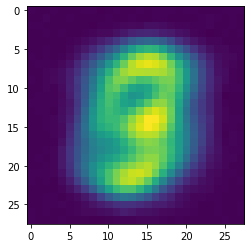

In [11]:
plt.imshow(recon_mnist[1,:].reshape(28,28).detach().numpy())

# Simple realization

In [3]:
def elbo(recon_rna, rna, z, logvar, mu, beta=0.01):
    loss_recon_rna = F.mse_loss(rna, recon_rna)

    loss_kl = beta * 0.5 * torch.sum(- logvar + torch.exp(logvar) + mu * mu - 1)

    loss = loss_recon_rna + loss_kl
    return loss, loss_recon_rna, loss_kl

In [4]:
def train_mnist(model, data_loader, beta = 0.01):
    model.train()

    total_loss = 0
    total_loss_recon_rna = 0
    total_loss_kl = 0
    for data, label in data_loader:
        optimizer.zero_grad()
        data = data.view(-1,784).to(device)
        recon_rna, z, mu, logvar = model(data)
        # print(mu.shape)
        # print(z.shape)
        loss = elbo(recon_rna, data, z, logvar, mu, beta = beta)
        total_loss += loss[0]
        total_loss_recon_rna += loss[1]
        total_loss_kl += loss[2]
        current_loss = loss[0]
        current_loss.backward()
        optimizer.step()
    
    return total_loss.item() / len(data_loader), total_loss_recon_rna.item() / len(data_loader), total_loss_kl.item() / len(data_loader), mu

In [5]:
def test_mnist(model, data_loader):
    model.eval()
    test_loss = 0
    for data , label in data_loader:
        data = data.view(-1,784).to(device)
        # recon_rna, mu, logvar = model(data)
        recon_rna, z, mu, logvar = model(data.to(device))
        z = z.detach().cpu().numpy()
        test_loss += F.mse_loss(recon_rna, data).item() 
        break

    print("reconstruction loss", test_loss/len(data_loader))
    
    diff_ori = 0
    diff_recon = 0
    for j in np.arange(data.shape[0]):
        diff_ori += torch.norm(data[0,:] - data[j,:]).detach().item()
        diff_recon += torch.norm(recon_rna[0,:] - recon_rna[j,:]).detach().item()

    print("original difference between sample", diff_ori)
    print("reconstruction difference between samples", diff_recon)

    
    return z, test_loss, recon_rna

In [7]:
model_vae = vae(in_channels = 784, latent_channels = 8, layer1_channels = 128, layer2_channels = 64).to(device)
optimizer = torch.optim.Adam(model_vae.parameters(), lr=5e-5, weight_decay=0.01)

for epoch in range(0, 21):
    loss, loss_mse, loss_kl, mu = train_mnist(model_vae, data_loader = train_loader, beta=0.5)
    if epoch % 5 == 0:
        log = "Epoch: {:03d}, Total loss: {:.5f}, Recon RNA loss: {:.5f}, KL loss: {:.5f}"
        print(log.format(epoch, loss, loss_mse, loss_kl))
        # print(mu)

Epoch: 000, Total loss: 0.41134, Recon RNA loss: 0.11551, KL loss: 0.29584
Epoch: 005, Total loss: 0.07824, Recon RNA loss: 0.07575, KL loss: 0.00249
Epoch: 010, Total loss: 0.07840, Recon RNA loss: 0.07822, KL loss: 0.00018


KeyboardInterrupt: 

reconstruction loss 4.102279742558797e-05
original difference between sample 309.07257080078125
reconstruction difference between samples 0.0005633276776961793


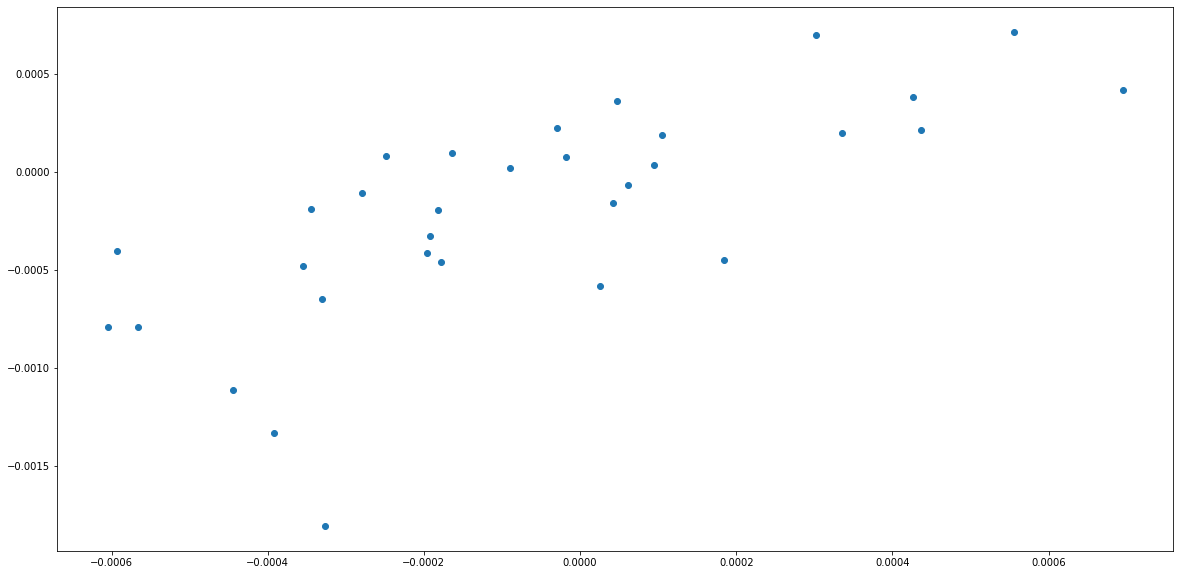

In [9]:
z, loss_val, recon_mnist = test_mnist(model_vae, test_loader)
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot()
ax.scatter(z[:,0], z[:,1])
plt.show()

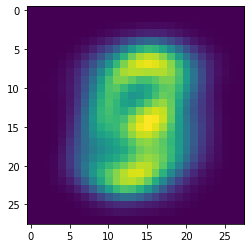

In [10]:
plt.imshow(recon_mnist[1,:].reshape(28,28).detach().numpy())

# Aligned VAE

In [ ]:
class testDataset(Dataset):

    def __init__(self, batch):
        transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
        train_dataset = torchvision.datasets.MNIST(
            root = './torch_dataset', train = True, download = True, transform = transform
        )
        # load training data and test data
        train_loader = torch.utils.data.DataLoader(
            dataset = train_dataset, batch_size = batch, shuffle = True, num_workers = 4, pin_memory = True
        )

        # subset first 512 images for training
        dataiter = iter(train_loader)
        images, labels = dataiter.next()

        mnist = images.squeeze().reshape(batch, 28*28)
        print(mnist.shape)

        self.expr_ATAC = mnist[:int(batch/2),:]
        self.expr_RNA = mnist[int(batch/2):,:]



        # self.transform = transform
        self.expr_ATAC = torch.FloatTensor(mnist)
        self.expr_RNA = torch.FloatTensor(mnist)
        print(self.expr_ATAC.shape)
        print(self.expr_RNA.shape)
        
    def __len__(self):
        # number of cells
        return len(self.expr_ATAC)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # index denote the index of the cell
        sample = {'ATAC': self.expr_ATAC[idx,:], 'RNA':self.expr_RNA[idx,:], 'index':idx}
        
        # if self.transform:
        #     sample = self.transform(sample)
        
        return sample

In [3]:
def dist_loss_kl(recon_atac, recon_rna, atac, rna, z, diff_atac, diff_rna, logvarz, muz, lamb, dist_loss_type = "cosine", beta=0.01):

    # Checked dimesion correct
    loss_recon_rna = F.mse_loss(rna, recon_rna)
    loss_recon_atac = F.mse_loss(atac, recon_atac)

    # only one 
    loss_recon_atac = torch.tensor(0)
    # loss_recon_rna = 0
    # cosine similarity loss, don't forget to normalize the matrix before calculate inner product
    if dist_loss_type == "cosine":
        # diff_atac and diff_rna are only constant, but better to be normalized
        Sim = pairwise_distance(z)
        # normalize latent similarity matrix
        Sim = Sim / torch.norm(Sim, p='fro')

        # inner product loss, maximize, so add negative before, in addition, make sure those two values are normalized, with norm 1
        loss_dist_atac = - lamb * torch.sum(diff_atac * Sim)
        loss_dist_rna = - lamb * torch.sum(diff_rna * Sim)

    # pearson correlationship
    elif dist_loss_type == "pearson":
        Sim = pairwise_distance(z)
        Vs = Sim - torch.mean(Sim)

        Vd_atac = diff_atac - torch.mean(diff_atac)
        Vd_rna = diff_rna - torch.mean(diff_rna)

        # maximize correlationship
        loss_dist_atac = - lamb * torch.sum(Vs * Vd_atac) / (torch.sqrt(torch.sum(Vs ** 2)) * torch.sqrt(torch.sum(Vd_atac ** 2)))
        loss_dist_rna = - lamb * torch.sum(Vs * Vd_rna) / (torch.sqrt(torch.sum(Vs ** 2)) * torch.sqrt(torch.sum(Vd_rna ** 2)))
    
    # mse loss
    elif dist_loss_type == "mse":
        loss_dist_atac = lamb * F.mse_loss(diff_atac.reshape(-1), pairwise_distance(z).reshape(-1))
        loss_dist_rna = lamb * F.mse_loss(diff_rna.reshape(-1), pairwise_distance(z).reshape(-1))
    
    # No distance loss
    else:
        loss_dist_atac = torch.tensor(0)
        loss_dist_rna = torch.tensor(0)

    loss_kl = beta * 0.5 * torch.sum(- logvarz + torch.exp(logvarz) + muz * muz - 1)

    loss = loss_recon_rna + loss_recon_atac + loss_dist_atac + loss_dist_rna + loss_kl
    return loss, loss_recon_rna, loss_recon_atac,  loss_dist_atac,  loss_dist_rna, loss_kl

In [4]:
def train_vae(model, data_loader, lamb = 1, beta = 0.01, similarity = "DPT", dist_loss_type = 'cosine'):
    model.train()

    total_loss = 0
    total_loss_recon_rna = total_loss_recon_atac = 0
    total_loss_dist_atac = total_loss_dist_rna = 0
    total_loss_kl = 0
    for data in data_loader:
        optimizer.zero_grad()
        batch_atac = data['ATAC'].to(device)
        batch_rna = data['RNA'].to(device)
        recon_atac, recon_rna, z, logvarz, muz = model(batch_atac, batch_rna)

        if similarity == "DPT":
            batch_diff_atac = DPT_atac[data['index'], :][:, data['index']]
            batch_diff_rna = DPT_rna[data['index'], :][:, data['index']]           
        
        elif similarity == "diffusion map":
            batch_diff_atac = diff_sim_atac[data['index'], :][:, data['index']]
            batch_diff_rna = diff_sim_rna[data['index'], :][:, data['index']]
        
        # No similarity
        else:
            batch_diff_atac = 0
            batch_diff_rna = 0
            dist_loss_type = 'None'


        loss = dist_loss_kl(recon_atac, recon_rna, batch_atac, batch_rna, z, batch_diff_atac, batch_diff_rna, logvarz, muz, lamb = lamb, dist_loss_type= dist_loss_type, beta = beta)
        total_loss += loss[0]
        total_loss_recon_rna += loss[1]
        total_loss_recon_atac += loss[2]
        total_loss_dist_rna += loss[3]
        total_loss_dist_atac += loss[4]
        total_loss_kl += loss[5]
        current_loss = loss[0]
        current_loss.backward()
        optimizer.step()
    
    scalar = data_loader.batch_size / 512
    return total_loss.item() * scalar, total_loss_recon_rna.item() * scalar, total_loss_recon_atac.item() * scalar, \
 total_loss_dist_rna.item() * scalar, total_loss_dist_atac.item() * scalar, total_loss_kl.item() * scalar

In [5]:
def test_vae(model, data_loader):
    model.eval()
    # model.train()
    for count, data in enumerate(data_loader):
        print("test", count)
        recon_atac, recon_rna, z, logvarz, muz = model(torch.FloatTensor(data['ATAC']).to(device), data['RNA'].to(device))

        # in evaluation mode z = muz
        z = z.detach().cpu().numpy()
        
        print("ATAC reconstruction loss", F.mse_loss(data['ATAC'].to(device), recon_atac).item())
        print("RNA reconstruction loss", F.mse_loss(data['RNA'].to(device), recon_rna).item())
        # print(data['ATAC'])
        print("RNA")
        # print(torch.unique(data['RNA'],dim = 1))
        
        for j in np.arange(data['RNA'].shape[0]):
            print("original difference between sample")
            print(torch.norm(data['RNA'][0,:] - data['RNA'][j,:]))
            print("reconstruction difference between samples")
            print(torch.norm(recon_rna[0,:] - recon_rna[j,:]))

        print()
        print("z")
        print(z)

    return z, recon_atac, recon_rna

In [6]:
batch = 1024
test_mnist = testDataset(batch)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


torch.Size([1024, 784])
torch.Size([1024, 784])
torch.Size([1024, 784])


In [7]:
len(test_mnist)

1024

In [8]:
model_vae = aligned_vae(in_channels_atac=28*28, in_channels_rna=28*28, latent_channels_atac=4, latent_channels_rna=4, latent_channels_z=2, layer1_channels= 32, layer2_channels=16).to(device)
optimizer = torch.optim.Adam(model_vae.parameters(), lr=1e-4, weight_decay=0.01)

for epoch in range(0, 151):

    loss, l1, l2, l3, l4, l5 = train_vae(model = model_vae, data_loader = train_loader, lamb = 100, beta=0.01, similarity = "None")
    if epoch % 10 == 0:
        log = "Epoch: {:03d}, Total loss: {:.5f}, Recon RNA loss: {:.5f}, Recon ATAC loss {:.5f}, Dist RNA loss {:.5f}, Dist ATAC loss {:.5f}, KL loss: {:.5f}"
        print(log.format(epoch, loss, l1, l2, l3, l4, l5))

Epoch: 000, Total loss: 0.38828, Recon RNA loss: 0.26600, Recon ATAC loss 0.00000, Dist RNA loss 0.00000, Dist ATAC loss 0.00000, KL loss: 0.12228
Epoch: 010, Total loss: 0.33350, Recon RNA loss: 0.23094, Recon ATAC loss 0.00000, Dist RNA loss 0.00000, Dist ATAC loss 0.00000, KL loss: 0.10256
Epoch: 020, Total loss: 0.30044, Recon RNA loss: 0.21515, Recon ATAC loss 0.00000, Dist RNA loss 0.00000, Dist ATAC loss 0.00000, KL loss: 0.08529
Epoch: 030, Total loss: 0.27384, Recon RNA loss: 0.20388, Recon ATAC loss 0.00000, Dist RNA loss 0.00000, Dist ATAC loss 0.00000, KL loss: 0.06995
Epoch: 040, Total loss: 0.25061, Recon RNA loss: 0.19414, Recon ATAC loss 0.00000, Dist RNA loss 0.00000, Dist ATAC loss 0.00000, KL loss: 0.05647
Epoch: 050, Total loss: 0.22995, Recon RNA loss: 0.18511, Recon ATAC loss 0.00000, Dist RNA loss 0.00000, Dist ATAC loss 0.00000, KL loss: 0.04484
Epoch: 060, Total loss: 0.21233, Recon RNA loss: 0.17734, Recon ATAC loss 0.00000, Dist RNA loss 0.00000, Dist ATAC lo

test 0
ATAC reconstruction loss 0.1315058171749115
RNA reconstruction loss 0.08010965585708618
RNA
original difference between sample
tensor(0.)
reconstruction difference between samples
tensor(0., grad_fn=<NormBackward0>)
original difference between sample
tensor(9.2906)
reconstruction difference between samples
tensor(0., grad_fn=<NormBackward0>)
original difference between sample
tensor(11.4801)
reconstruction difference between samples
tensor(0., grad_fn=<NormBackward0>)
original difference between sample
tensor(11.3730)
reconstruction difference between samples
tensor(0., grad_fn=<NormBackward0>)
original difference between sample
tensor(9.3132)
reconstruction difference between samples
tensor(0., grad_fn=<NormBackward0>)
original difference between sample
tensor(10.4810)
reconstruction difference between samples
tensor(0., grad_fn=<NormBackward0>)
original difference between sample
tensor(11.1087)
reconstruction difference between samples
tensor(0., grad_fn=<NormBackward0>)
origi

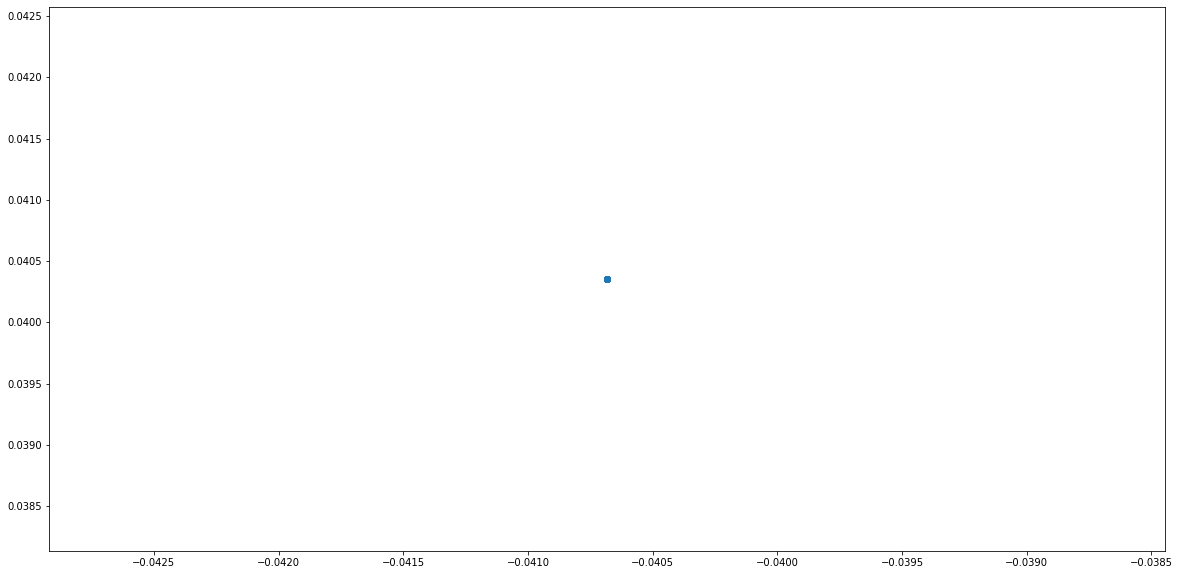

In [9]:
z, recon_atac, recon_rna = test_vae(model_vae, test_loader)
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot()
ax.scatter(z[:,0], z[:,1])

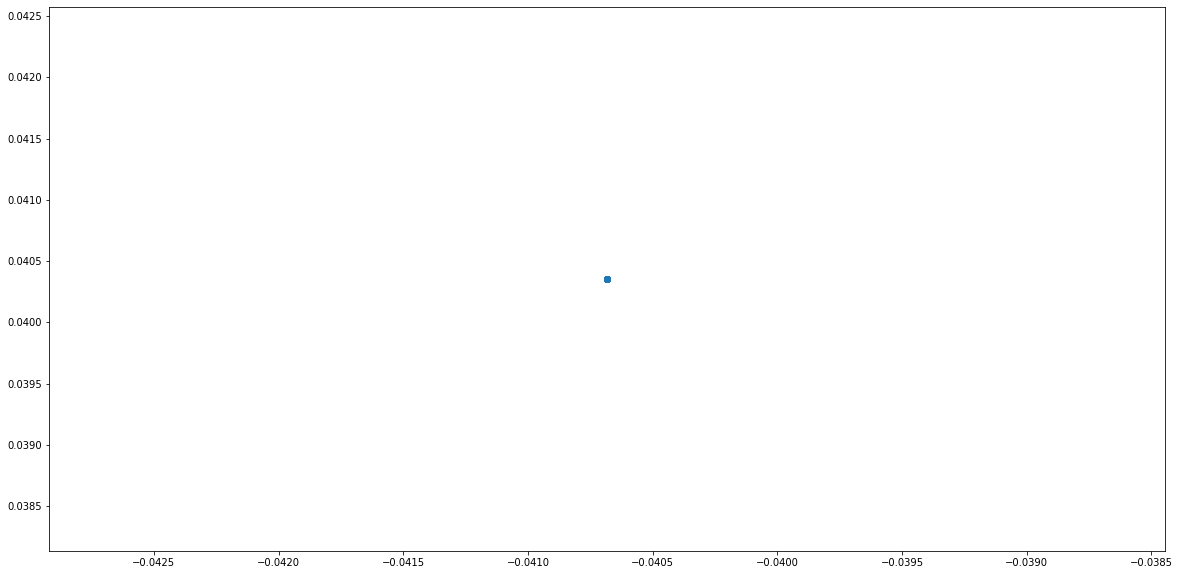

In [10]:
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot()
ax.scatter(z[:,0], z[:,1])

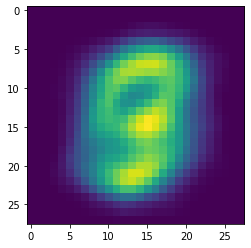

In [11]:
plt.imshow(recon_rna[3,:].reshape(28,28).detach().numpy())

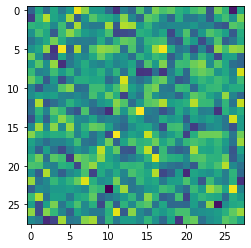

In [13]:
plt.imshow(recon_atac[3,:].reshape(28,28).detach().numpy())